# Genetic Algorithm CReM to Generate an anti-NG Compound 

We use CReM to generate compounds from a promising anti-NG fragment. We test both a "grow" and a "mutate" method as well as two scoring methods, "regular" and "modified".  

* ```mut```: Part of the original molecule is replaced by changing the existing atoms and bonds in the original molecule.
* ```grow```: The molecule expands by adding atoms in a defined region (within a specific "radius").
* ```regular_score```: Raw output from the Chemprop model. 
* ```modified_score```: Additional factors (like synthesizability, toxicity, and similarity to known antibiotics) are considered.


In [ ]:
import os
from crem_pipeline import run_crem

# Define the directory for storing intermediate predictions and results
DIR = '../out/crem/ngcpd_crem/'  # Results will be stored in 'grow/' or 'mutate/' subfolders
ORIG_MOL_SMI = 'Clc1ccc(c(c1)Cl)N1CC[C@@H](C1)NC(=O)c1cn[nH]n1'  # Original molecule SMILES
ORIG_FRAG_SMI = 'CC(=O)NC1CCN(C2=CC=C(Cl)C=C2Cl)C1'  # Original fragment SMILES

# Parameters for molecule growth/mutation
MAX_ATOM_RANGE = [4,6,8,10]  # Max number of atoms in the new fragment
MIN_ATOM_RANGE = [0]  # Min number of atoms in the fragment (0 replaces hydrogens)
RADIUS_RANGE = [2,3]  # Radius of context for fragment replacement
MIN_INC_RANGE = [-2]  # Min change in number of atoms for mutation (only for mutation)
MAX_INC_RANGE = [2]  # Max change in number of atoms for mutation (only for mutation)

# Other configuration parameters
NUM_TOP_TO_GET = 5  # Number of top molecules to select
NUM_RANDOM_TO_GET = 5  # Number of random molecules to select
NUM_ITERS = 5  # Number of iterations to run the algorithm
CPD_FILTER = 'both'  # Filter for PAINS and/or BRENK alerts ('both' means both)
MODEL_PATH = '../melis_gonorrhea/models/bayHOv210262022/FINALbayHO11152022/'  # Path to the Chemprop model
HIT_COLUMN = 'hit'  # Column name for hit predictions in the model

# Loop through different score types ('modified_score' or 'regular_score')
for score_path in ['modified_score', 'regular_score']:
    REGULAR_SCORE = True if score_path == 'regular_score' else False  # Toggle between regular and modified scores
    OUT_DIR = DIR + score_path + '/'  # Output directory based on score type
    os.mkdir(OUT_DIR)  # Create the output directory

    # Loop through growth and mutation methods
    for mut_or_grow in ['mut', 'grow']:
        METHOD = mut_or_grow  # Set the method (either 'grow' or 'mut')

        # Run CReM with the current parameters
        run_crem(out_dir=OUT_DIR, orig_frag_smi=ORIG_FRAG_SMI, orig_mol_smi=ORIG_MOL_SMI, 
                 max_atom_range=MAX_ATOM_RANGE, min_atom_range=MIN_ATOM_RANGE, radius_range=RADIUS_RANGE, 
                 min_inc_range=MIN_INC_RANGE, max_inc_range=MAX_INC_RANGE, num_iters=NUM_ITERS, 
                 method=METHOD, regular_score=REGULAR_SCORE, num_top_to_get=NUM_TOP_TO_GET, 
                 num_random_to_get=NUM_RANDOM_TO_GET, cpd_filter=CPD_FILTER, model_path=MODEL_PATH, 
                 hit_column=HIT_COLUMN)

# Prioritizing CReM Candidates 

Next, we downselect the most promising candidates generated by CReM. The goal is to identify molecules that are active, synthetically feasible, and safe while avoiding compounds that are too similar to known antibiotics or training set compounds.

* ```HIT_TRESH = 0.7```: only consider compounds with a predicted score above 0.7
* ```SASCORE_TRESH = 3```: only consider compounds with synthetic accessibility above 3. 
* ```TAN_TO_ABX = 0.5```: filter out compounds that are too similar to known antibiotics. 
* ```*_TOX_THRESH = 0.2```: filter out compounds that seem toxic based on HEPG2 (liver) and PRIM (primary) toxicity 
* ```TAN_TO_TRAIN_SET = 0.5```: filter out compounds that are too similar to training set
* We also filter out beta-lactame containing molecules. 

In [ ]:
# shut off warnings
from rdkit import RDLogger, Chem                                                                                                                                                          
RDLogger.DisableLog('rdApp.*')

# imports
from crem_helpers import collate_crem_molecules_from_multiple_rounds, filter_crem_dataframe, analyze_crem_df

# Define the paths for results from different rounds of CReM pipeline, categorized by score type and method (grow or mutate)
RESULTS_PATHS = [
    'modified_score/grow',  # New score for 'grow' method
    'modified_score/mutate',  # New score for 'mutate' method
    'regular_score/grow',  # Old score for 'grow' method
    'regular_score/mutate'  # Old score for 'mutate' method
]

# Define the output directory to store the final results
OUT_DIR = '../out/crem/ng_crem/'

# Define column names for SMILES and hit score in the results dataframe
SMI_COL = 'SMILES'
HIT_COL = 'hit'

# Set threshold values for hit score and synthetic accessibility score (SAScore)
HIT_THRESH = 0.7  # Only keep molecules with hit score > 0.7
SASCORE_THRESH = 3  # Only keep molecules with SAScore < 3 (easier to synthesize)

# Set threshold for Tanimoto similarity to known antibiotics (avoid similarity > 0.5)
TAN_TO_ABX = 0.5
ABX_PATH = '../downselection/559_known_abx.csv'  # Path to antibiotics dataset
ABX_SMILES_COL = 'Smiles'  # Column containing SMILES strings for antibiotics

# Set toxicity thresholds for HepG2 (liver toxicity) and Primary toxicity
HEPG2_TOX_THRESH = 0.2  # Exclude molecules with HepG2 toxicity > 0.2
PRIM_TOX_THRESH = 0.2  # Exclude molecules with Primary toxicity > 0.2

# Set Tanimoto similarity threshold to training set (avoid similarity > 0.5)
TAN_TO_TRAIN_SET = 0.5
TRAIN_SET_PATH = '../data/training_data/SA/combined_SA_screen_39K.csv'  # Path to training set dataset
TRAIN_SET_SMILES_COL = 'SMILES'  # Column containing SMILES for training set compounds
TRAIN_SET_JUST_ACTIVES = False  # Whether to consider only active compounds in the training set

# Define betalactam structure to filter out molecules containing this fragment
betalactam = 'O=C1CCN1'  # Betalactam ring structure (common in antibiotics)
betalactam_mol = Chem.MolFromSmiles(betalactam)  # Convert SMILES to RDKit molecule object
PATTERNS = [betalactam_mol]  # List of undesirable patterns (betalactam)

# Define the original molecule for comparison and set a threshold for its Tanimoto similarity
ORIG_MOL_SMI = 'Clc1ccc(c(c1)Cl)N1CC[C@@H](C1)NC(=O)c1cn[nH]n1'  # Original molecule SMILES
ORIG_MOL = Chem.MolFromSmiles(ORIG_MOL_SMI)  # Convert to RDKit molecule object
ORIG_MOL_TAN_THRESH = 1.0  # Set the Tanimoto threshold for original molecule similarity (1.0 means exact match)

# Flag to control whether to display results inline (e.g., in Jupyter notebooks)
DISPLAY_IN_LINE = True

# Collate molecules from multiple CReM pipeline rounds (with filtering based on hit score)
allmolsdf = collate_crem_molecules_from_multiple_rounds(RESULTS_PATHS, OUT_DIR, smi_col=SMI_COL, hit_col=HIT_COL)

# Save the filtered and collated molecules to a CSV file for further analysis
allmolsdf.to_csv(OUT_DIR + 'all_crem_ngcpd_generated_mols.csv', index=False)

# Display the final dataframe of selected molecules (optional, for inspection)
allmolsdf

,Score,Grow_or_Mut,Algorithm_Params,Round,SMILES,hit
0,modified_score,grow,10_maxatom_0_minatom_2_radius,Round 2,O=C1CC(Sc2cc(N3CC[C@H](NC(=O)c4n[nH]nc4C(=O)OC...,0.676424
1,modified_score,grow,10_maxatom_0_minatom_2_radius,Round 2,O=C1CC(Sc2cc(N3CC[C@H](NC(=O)c4n[nH]nc4C(=O)OC...,0.661152
2,modified_score,grow,10_maxatom_0_minatom_2_radius,Round 2,O=C1CC(Sc2cc(N3CC[C@H](NC(=O)c4n[nH]nc4C(=O)OC...,0.656603
3,modified_score,grow,10_maxatom_0_minatom_2_radius,Round 2,O=C1CC(Sc2cc(N3CC[C@H](NC(=O)c4n[nH]nc4C(=O)OC...,0.690478
4,modified_score,grow,10_maxatom_0_minatom_2_radius,Round 2,O=C1CC(Sc2cc(N3CC[C@H](NC(=O)c4n[nH]nc4C(=O)Oc...,0.782609
...,...,...,...,...,...,...
1294,chemprop_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_3_radius,Round 3,O=C(Cc1ccc(O)cc1Cl)N[C@H]1CCN(c2ccc(Cl)cc2Cl)C1,0.559532
1295,chemprop_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_3_radius,Round 3,COc1cc(O)ccc1CC(=O)N[C@H]1CCN(c2ccc(Cl)cc2Cl)C1,0.457275
1296,chemprop_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_3_radius,Round 3,O=C(Cc1ccc(O)cc1F)N[C@H]1CCN(c2ccc(Cl)cc2Cl)C1,0.495008
1297,chemprop_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_3_radius,Round 3,N#Cc1cc(O)ccc1CC(=O)N[C@H]1CCN(c2ccc(Cl)cc2Cl)C1,0.464079


original length:  518203
deduplicated on smiles:  423095


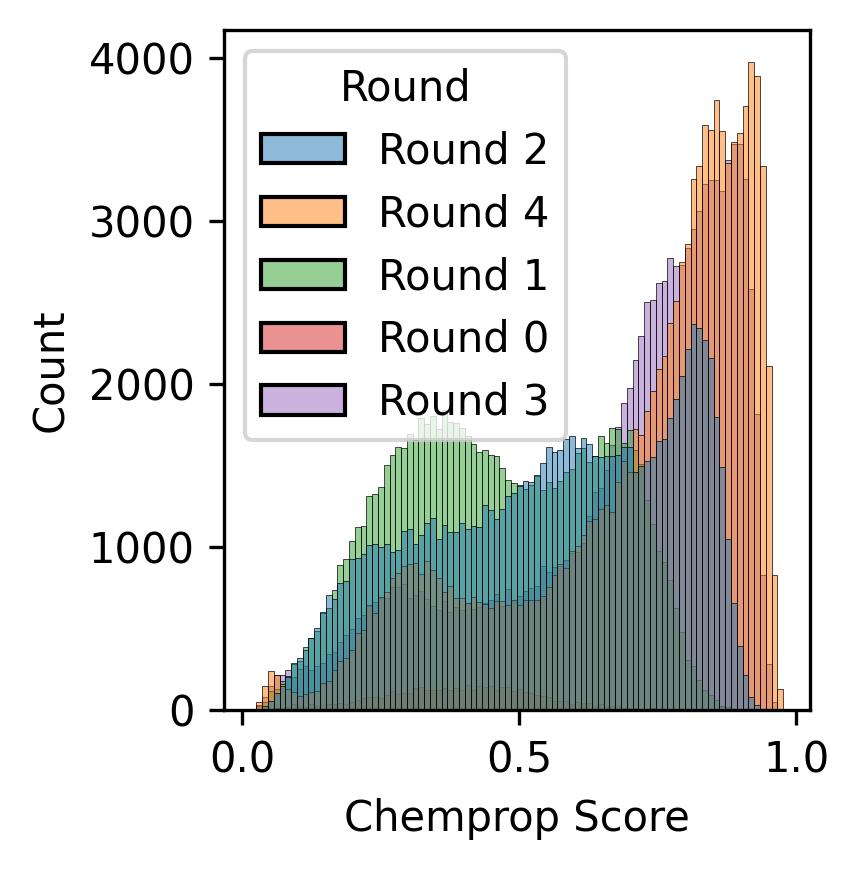

scores > 0.7:  180827


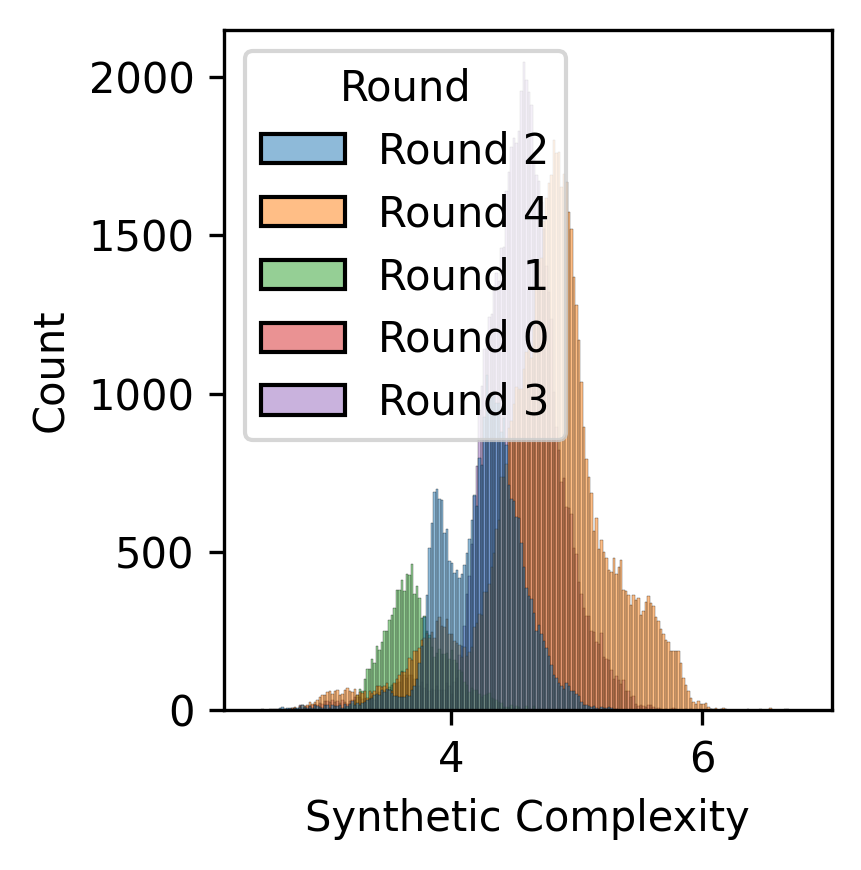

SAScore < 3:  763


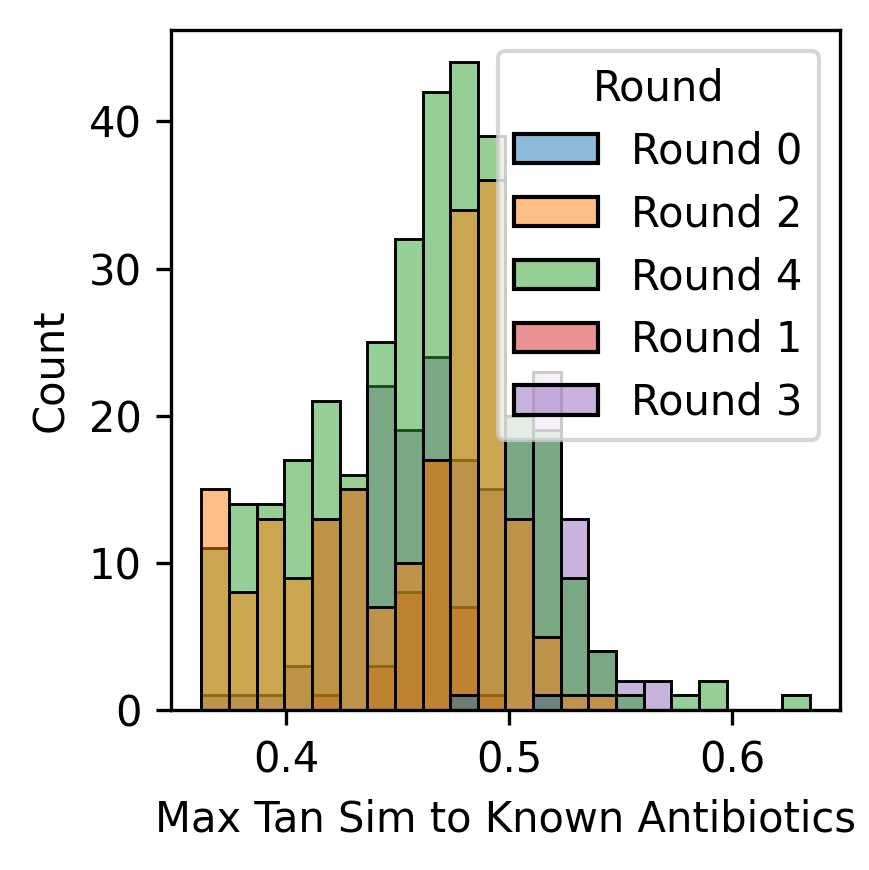

Tan Sim to Abx < 0.5:  627


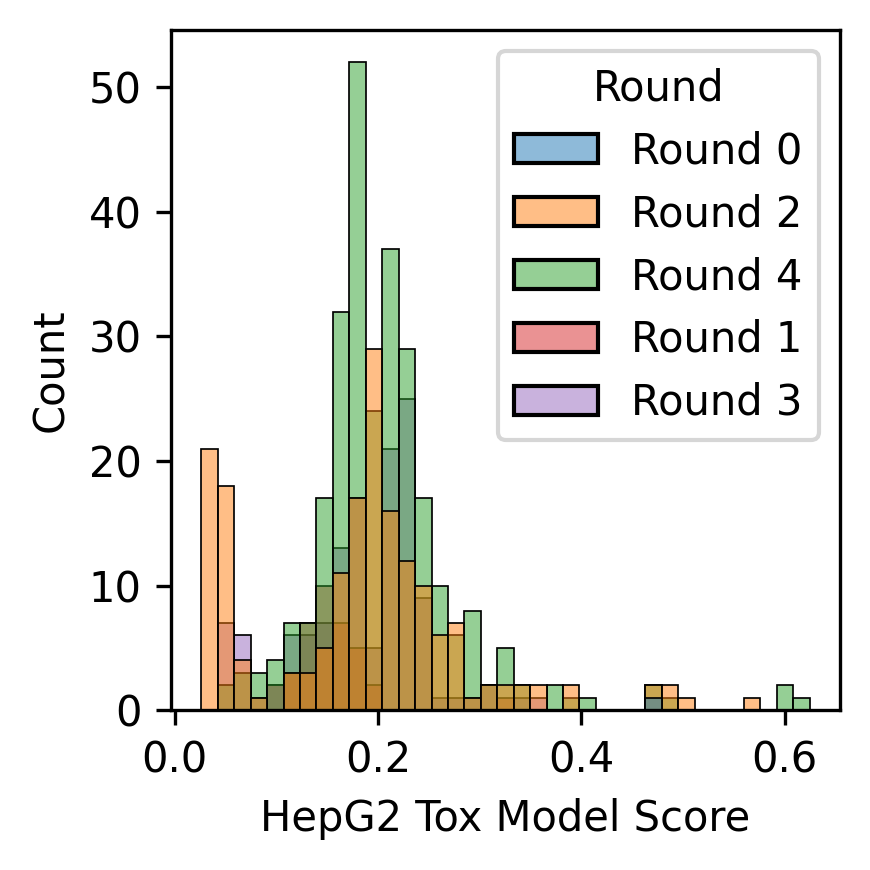

HepG2 pred tox < 0.2:  357


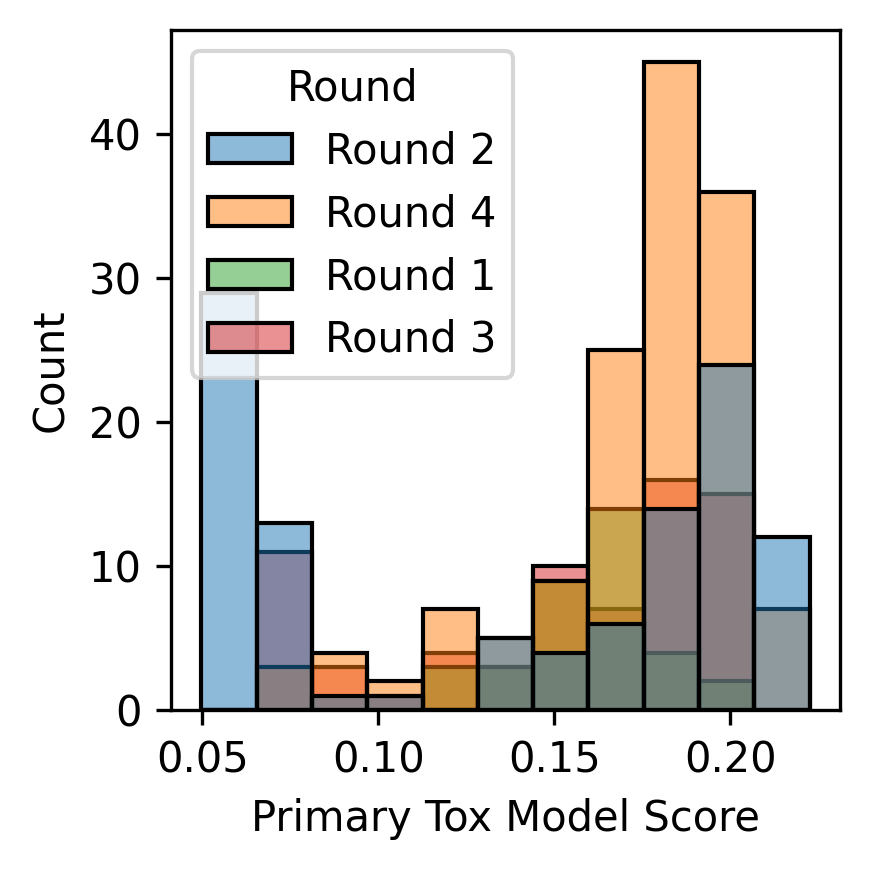

Primary pred tox < 0.2:  318


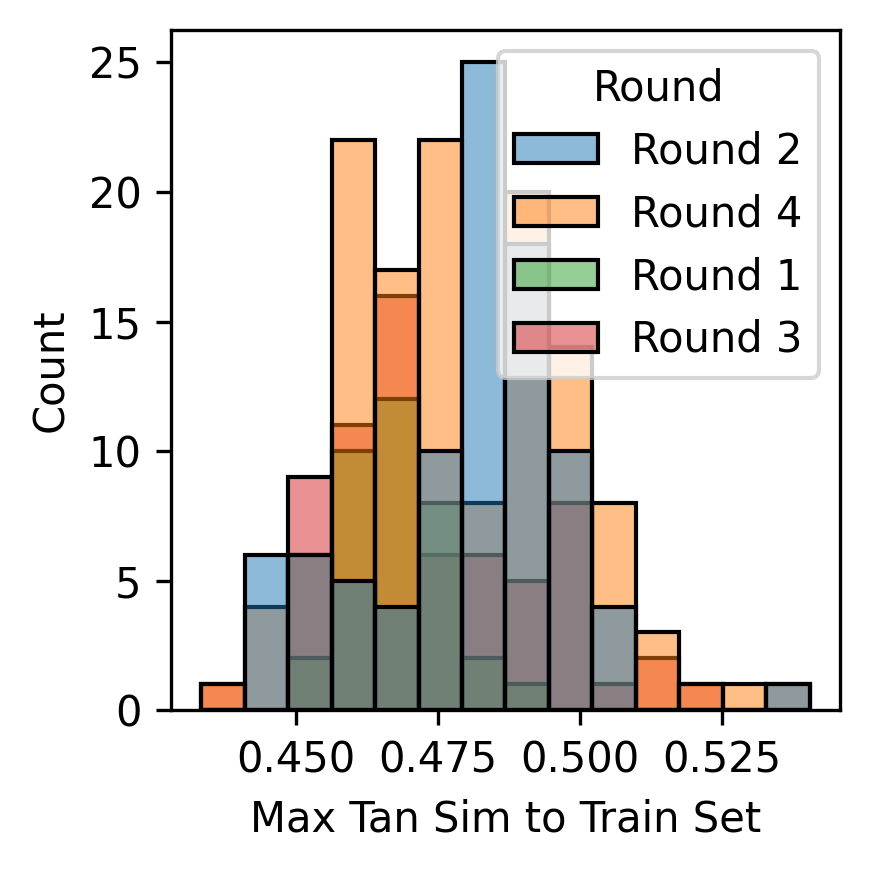

Max Tan Sim to TS < 0.5:  285
excluding pattern:  285


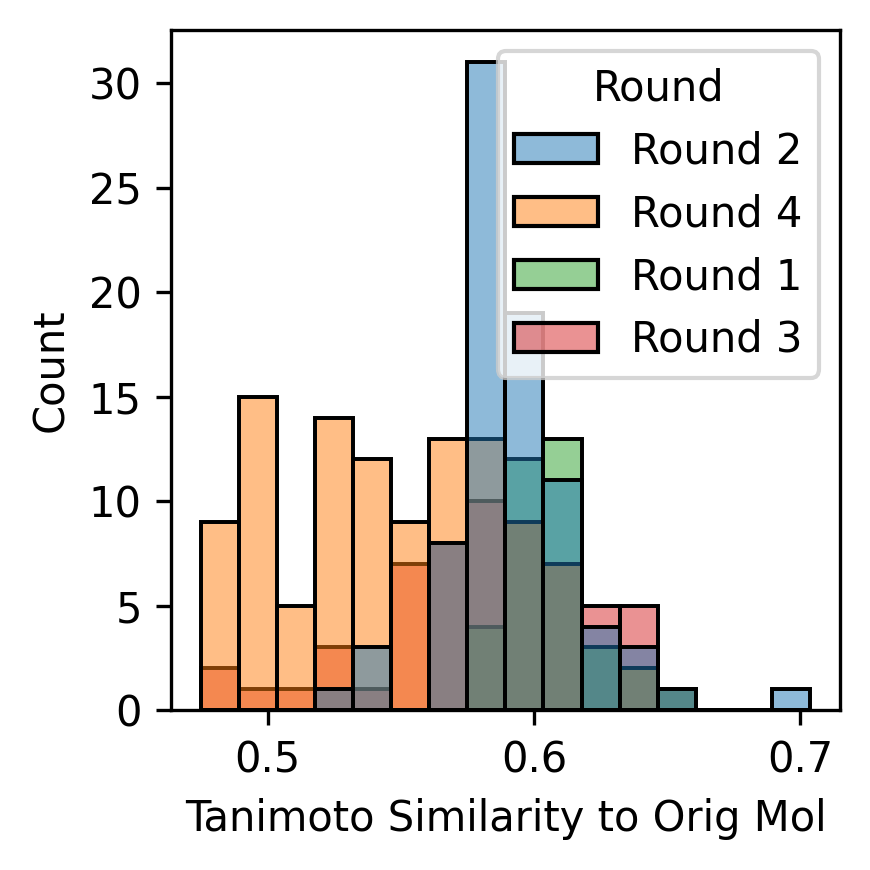

Tan sim to orig mol < 1.0:  285


,Score,Grow_or_Mut,Algorithm_Params,Round,SMILES,hit,sa_score,max_tan_sim_to_abx,hepg2_pred_tox,primary_pred_tox,max_tan_sim_to_ts,tan_sim_to_orig_mol
0,modified_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_2_radius,Round 2,O=C(N[C@H]1CCN(c2ccc(Cl)cc2Cl)C1)c1ncccc1Cl,0.701781,2.580029,0.436454,0.122280,0.143661,0.453462,0.656489
1,modified_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_2_radius,Round 2,Cc1cc(C(=O)N[C@H]2CCN(c3ccc(Cl)cc3Cl)C2)c(Cl)c...,0.713328,2.568358,0.393337,0.185854,0.199496,0.441355,0.619469
2,modified_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_2_radius,Round 2,O=C(N[C@H]1CCN(c2ccc(Cl)cc2Cl)C1)c1cccc(Cl)c1Cl,0.746292,2.498822,0.393107,0.184862,0.198658,0.447323,0.609890
3,modified_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_2_radius,Round 2,O=C(N[C@H]1CCN(c2ccc(Cl)cc2Cl)C1)c1ccc(Cl)cc1Cl,0.708204,2.432047,0.375736,0.182174,0.193384,0.443548,0.636994
4,modified_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_2_radius,Round 2,O=C(CSc1cccc(Cl)c1Cl)N[C@H]1CCN(c2ccc(Cl)cc2Cl)C1,0.720584,2.720084,0.370690,0.195645,0.197246,0.474002,0.539804
...,...,...,...,...,...,...,...,...,...,...,...,...
280,chemprop_score,mutate,0_minsize_6_maxsize_-2_mininc_2_maxinc_3_radius,Round 3,CNC(=O)c1cc(Cl)c(Cl)c(C(=O)N[C@H]2CCN(c3ccc(Cl...,0.710925,2.757445,0.421235,0.180466,0.178091,0.449587,0.582564
281,chemprop_score,mutate,0_minsize_6_maxsize_-2_mininc_2_maxinc_3_radius,Round 3,CS(=O)(=O)c1cc(Cl)c(Cl)c(C(=O)N[C@H]2CCN(c3ccc...,0.704146,2.788995,0.489493,0.162548,0.183529,0.496923,0.508850
282,chemprop_score,mutate,0_minsize_6_maxsize_-2_mininc_2_maxinc_3_radius,Round 3,NC(=O)c1cc(Cl)c(Cl)c(C(=O)N[C@H]2CCN(c3ccc(Cl)...,0.742038,2.752907,0.420901,0.186763,0.196059,0.449132,0.582136
283,chemprop_score,mutate,0_minsize_6_maxsize_-2_mininc_2_maxinc_3_radius,Round 3,O=C(O)c1cc(Cl)c(Cl)c(C(=O)N[C@H]2CCN(c3ccc(Cl)...,0.793855,2.710600,0.446039,0.097094,0.110858,0.466864,0.556962


grow 0
mutate 285
regular score 132
modified score 153
round 0 0
round 1 35
round 2 82
round 3 60
round 4 108


In [67]:
# Filter the collated CReM dataframe based on specified criteria
selectedmolsdf = filter_crem_dataframe(
    allmolsdf,                   # Dataframe of all generated molecules
    SMI_COL,                     # Column containing SMILES strings
    HIT_COL,                     # Column containing hit scores
    OUT_DIR,                     # Output directory for saving filtered results
    hit_thresh=HIT_THRESH,       # Threshold for hit score (keep > 0.7)
    sascore_thresh=SASCORE_THRESH,  # Threshold for synthetic accessibility score (keep < 3)
    tan_to_abx=TAN_TO_ABX,       # Tanimoto similarity threshold to known antibiotics (keep < 0.5)
    abx_path=ABX_PATH,           # Path to antibiotics dataset
    abx_smiles_col=ABX_SMILES_COL,  # Column containing SMILES in antibiotics dataset
    hepg2_tox_thresh=HEPG2_TOX_THRESH,  # Threshold for HepG2 toxicity (keep < 0.2)
    prim_tox_thresh=PRIM_TOX_THRESH,    # Threshold for primary toxicity (keep < 0.2)
    tan_to_train_set=TAN_TO_TRAIN_SET,  # Tanimoto similarity threshold to training set (keep < 0.5)
    train_set_path=TRAIN_SET_PATH,     # Path to training set dataset
    train_set_smiles_col=TRAIN_SET_SMILES_COL,  # Column containing SMILES in training set
    train_set_just_actives=TRAIN_SET_JUST_ACTIVES,  # Whether to consider only active compounds in training set
    orig_mol=ORIG_MOL,             # Original molecule for comparison
    orig_mol_tan_thresh=ORIG_MOL_TAN_THRESH,  # Tanimoto similarity threshold to original molecule (keep < 1.0)
    patterns=PATTERNS,             # Patterns (e.g., betalactam) to exclude
    display=DISPLAY_IN_LINE        # Whether to display filtered molecules inline
)

# Display the filtered dataframe (e.g., in Jupyter Notebook)
display(selectedmolsdf)

# Analyze the filtered dataframe (e.g., assess statistics or distributions)
analyze_crem_df(selectedmolsdf)

# Save the filtered and downselected molecules to a CSV file for further use
selectedmolsdf.to_csv(OUT_DIR + 'final_crem_ngcpd_downselected_mols.csv', index=False)